In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
vanilla = pd.read_csv("./data/vanilla.csv")
vanilla["algorithm"] = "vanilla"
parfor = pd.read_csv("./data/parfor.csv")
parfor["algorithm"] = "parfor"
tiled = pd.read_csv("./data/tiled.csv")
tiled["algorithm"] = "tiled"
dac_notemp = pd.read_csv("./data/DAC_notemp.csv")
dac_notemp["algorithm"] = "dac_notemp"
dac_temp = pd.read_csv("./data/DAC_temp.csv")
dac_temp["algorithm"] = "dac_temp"
strassens = pd.read_csv("./data/strassens.csv")
strassens["algorithm"] = "strassens"

In [3]:
vanilla_median = vanilla.groupby(["threads", "N", "algorithm"]).median().reset_index()
parfor_median = parfor.groupby(["threads", "N", "algorithm"]).median().reset_index()
tiled_median = tiled.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
dac_notemp_median = dac_notemp.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
dac_temp_median = dac_temp.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()
strassens_median = strassens.groupby(["threads", "N", "param", "algorithm"]).median().reset_index()

dfs = [vanilla_median, parfor_median, tiled_median, dac_notemp_median, dac_temp_median, strassens_median]

In [4]:
for df in dfs:
    df["serial_runtime(ms)"] = df.apply(lambda r:
                                        df.query(f"N == {r['N']} and param == {r['param']} and threads == 1")
                                        ["runtime(ms)"].iloc[0], axis=1)
    df["Speedup"] = df["serial_runtime(ms)"] / df["runtime(ms)"]
    df["Efficiency"] = df["Speedup"] / df["threads"]

In [5]:
parfor_median["N"].unique(), parfor_median["threads"].unique()

(array([  64,  128,  256,  512, 1024, 2048]), array([ 1,  2,  4,  8, 12, 16]))

In [6]:
max_time = max(map(lambda df: df["runtime(ms)"].max(), dfs))
max_time

33196.850000000006

In [7]:
def plot_runtimes(df, x, y, title):
    colors = sns.color_palette("Spectral", 6)
    t = f"Runtimes of the {title} Algorithm"
    sns.lineplot(df[df["threads"] == 1], x=x, y=y, label="1 thread", c=colors[0])
    for i, threads in enumerate([2, 4, 8, 12, 16]):
        sns.lineplot(df[df["threads"] == threads], x=x, y=y, label=f"{threads} threads", c=colors[i+1])
    plt.title(t, weight="bold")
    plt.xlim(0, df[x].max())
    plt.ylim(0, max_time)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + ".png")
    plt.show()


def plot_strong_scaling(df, x, y, title, param_name=None):
    t = f"Strong Scaling of the {title} Algorithm"
    for p in df["param"].unique():
        sns.lineplot(df[df["param"] == p], x=x, y=y, errorbar=lambda x: (x.min(), x.max()), 
                     label=f"Real {y}" + (f" ({param_name} = {p})" if param_name else ""))
    if y == "Speedup":
        plt.axline((1, 1), (df[x].max(), df[x].max()), c="r", label=f"Ideal {y}")
    else:
        plt.axline((0, 1), (df[x].max(), 1), c="r", label=f"Ideal {y}")
    plt.title(t, weight="bold")
    plt.xlim(1, df[x].max())
    if y == "Speedup":
        plt.ylim(1, df[x].max())
    else:
        plt.ylim(0, 1.5)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + f" - {y}.png")
    plt.legend()
    if y == "Speedup":
        plt.grid()
    plt.show()


def plot_weak_scaling(df, x, y, title, param_name=None):
    t = f"Weak Scaling of the {title} Algorithm"
    for p in df["param"].unique():
        subset = df.query(f"N == 64 * threads and param == {p}")
        sns.lineplot(subset, x=x, y=y, errorbar=lambda x: (x.min(), x.max()),
                     label=f"Real {y}" + (f" ({param_name} = {p})" if param_name else ""))
    if y == "Speedup":
        plt.axline((1, 1), (subset[x].max(), subset[x].max()), c="r", label=f"Ideal {y}")
    else:
        plt.axline((0, 1), (subset[x].max(), 1), c="r", label=f"Ideal {y}")
    plt.title(t, weight="bold")
    plt.xlim(1, subset[x].max())
    if y == "Speedup":
        plt.ylim(1, subset[x].max())
    else:
        plt.ylim(0, 1.5)
    plt.gcf().set_size_inches(8, 6)
    plt.savefig("./figures/" + t + f" - {y}.png")
    plt.legend()
    if y == "Speedup":
        plt.grid()
    plt.show()
    

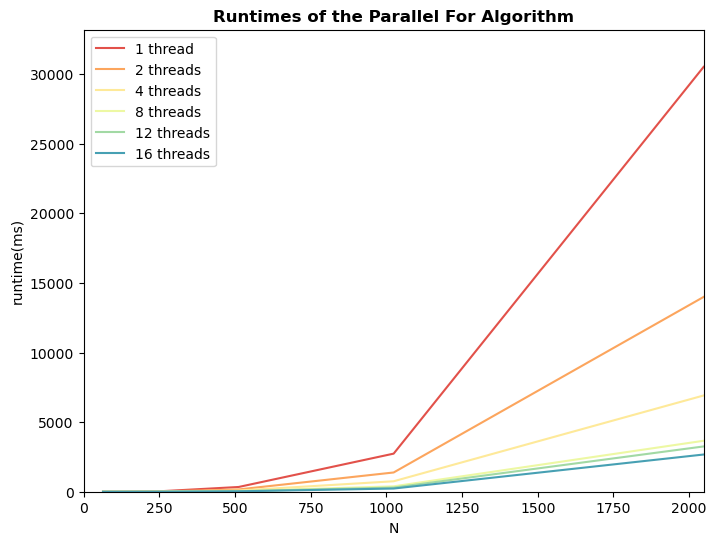

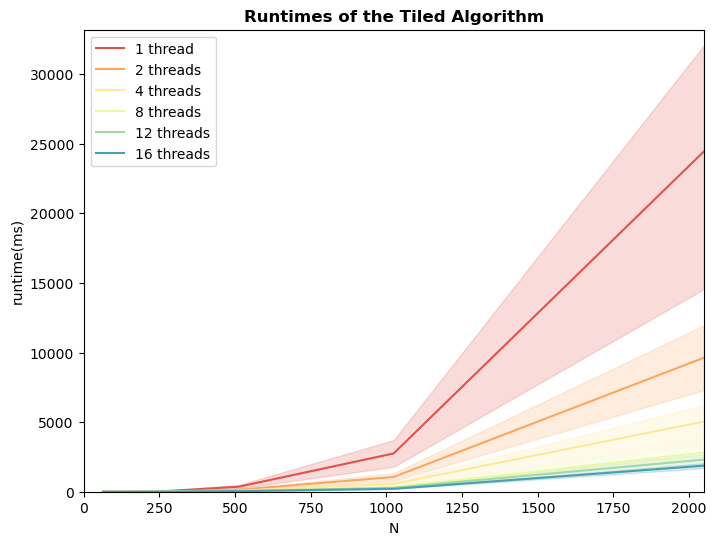

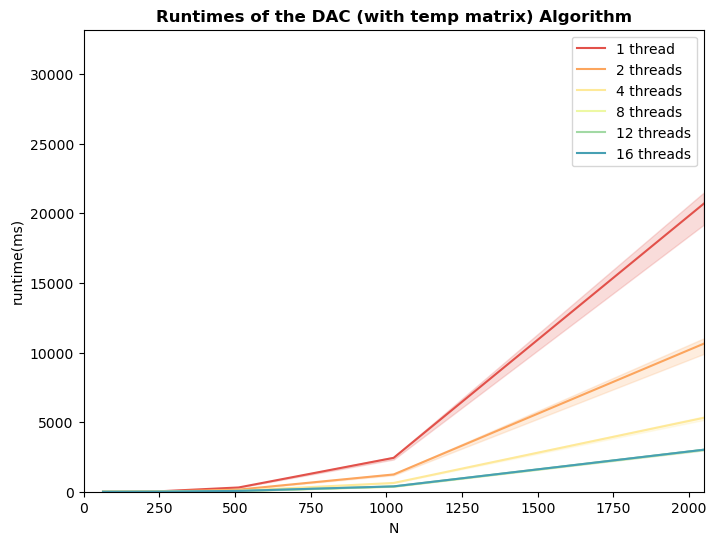

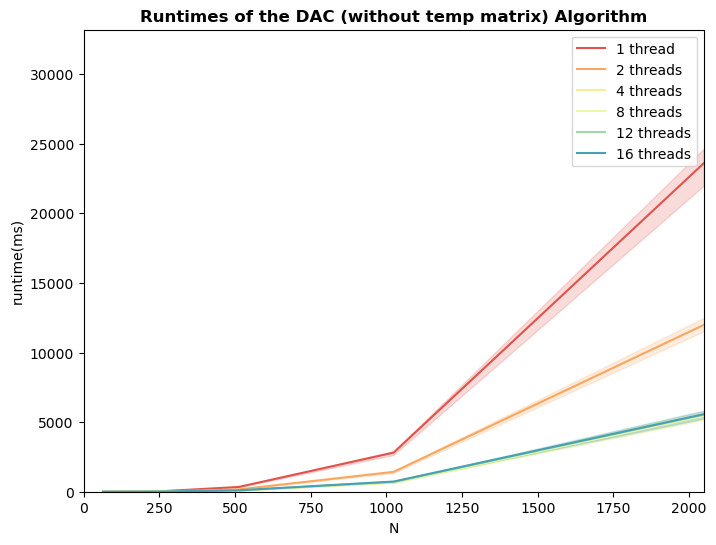

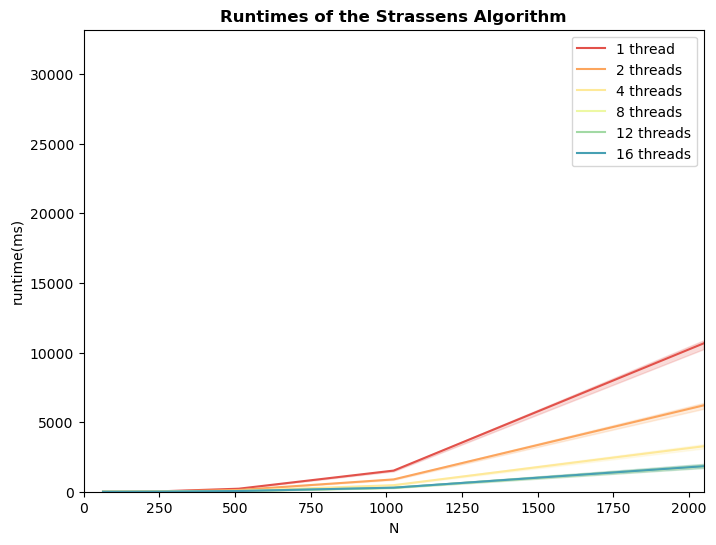

In [8]:
plot_runtimes(parfor_median, "N", "runtime(ms)", "Parallel For")
plot_runtimes(tiled_median, "N", "runtime(ms)", "Tiled")
plot_runtimes(dac_temp_median, "N", "runtime(ms)", "DAC (with temp matrix)")
plot_runtimes(dac_notemp_median, "N", "runtime(ms)", "DAC (without temp matrix)")
plot_runtimes(strassens_median, "N", "runtime(ms)", "Strassens")

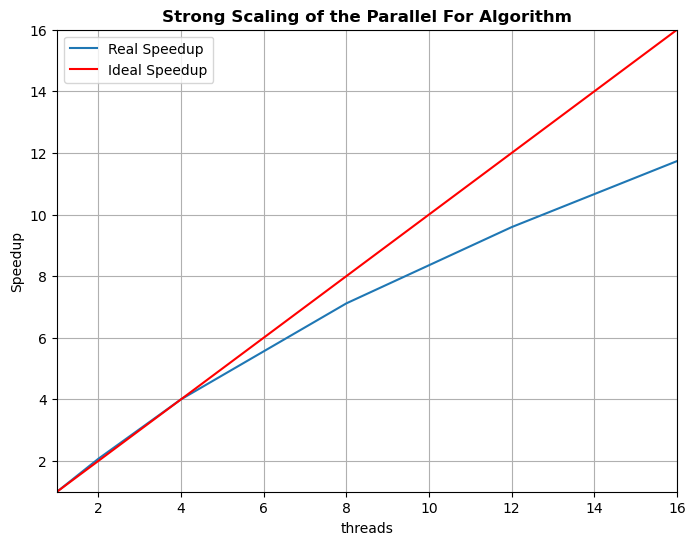

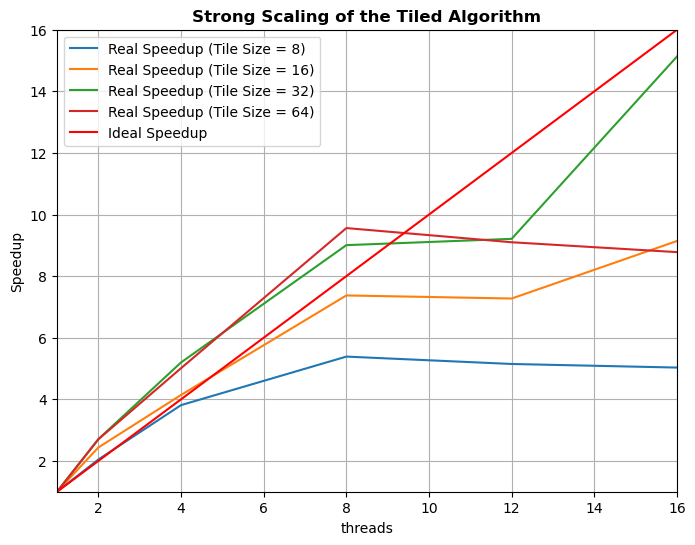

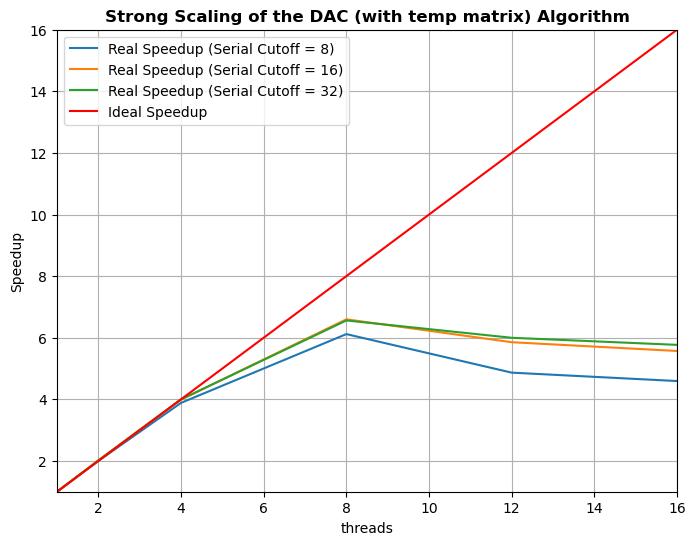

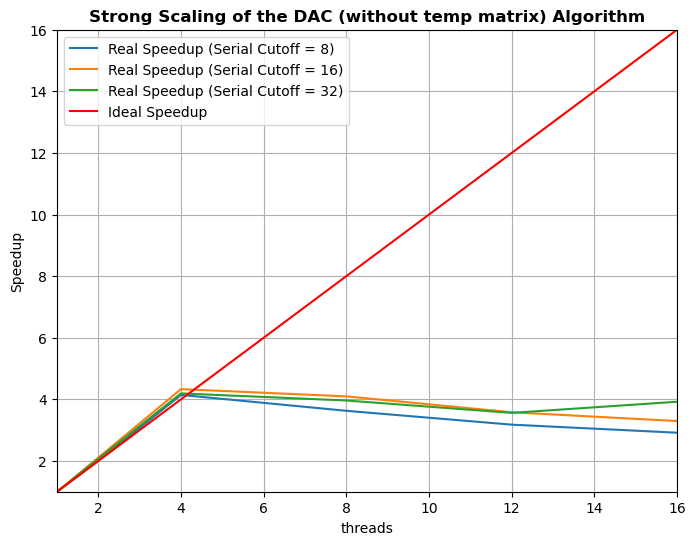

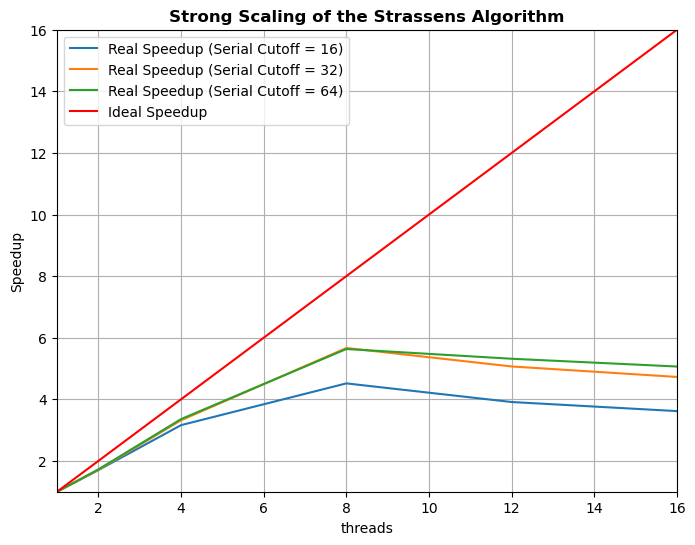

In [9]:
max_N = 512
plot_strong_scaling(parfor_median[parfor_median["N"] == max_N], "threads", "Speedup", "Parallel For")
plot_strong_scaling(tiled_median[tiled_median["N"] == max_N], "threads", "Speedup", "Tiled", "Tile Size")
plot_strong_scaling(dac_temp_median[dac_temp_median["N"] == max_N], "threads", "Speedup", "DAC (with temp matrix)", "Serial Cutoff")
plot_strong_scaling(dac_notemp_median[dac_notemp_median["N"] == max_N], "threads", "Speedup", "DAC (without temp matrix)", "Serial Cutoff")
plot_strong_scaling(strassens_median[strassens_median["N"] == max_N], "threads", "Speedup", "Strassens", "Serial Cutoff")

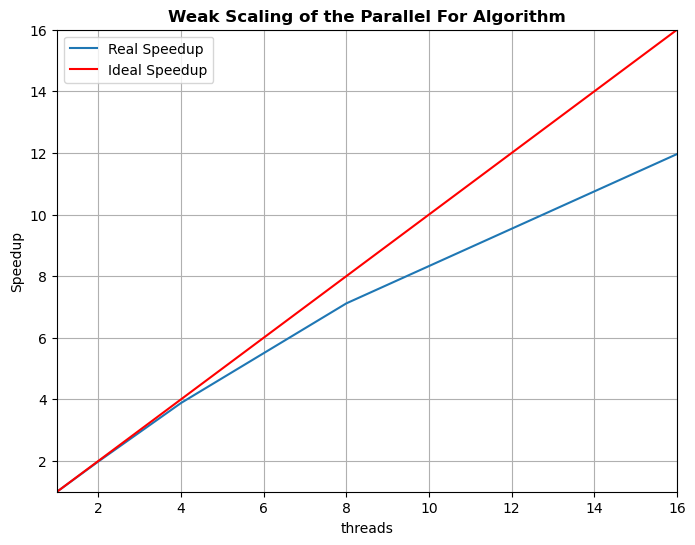

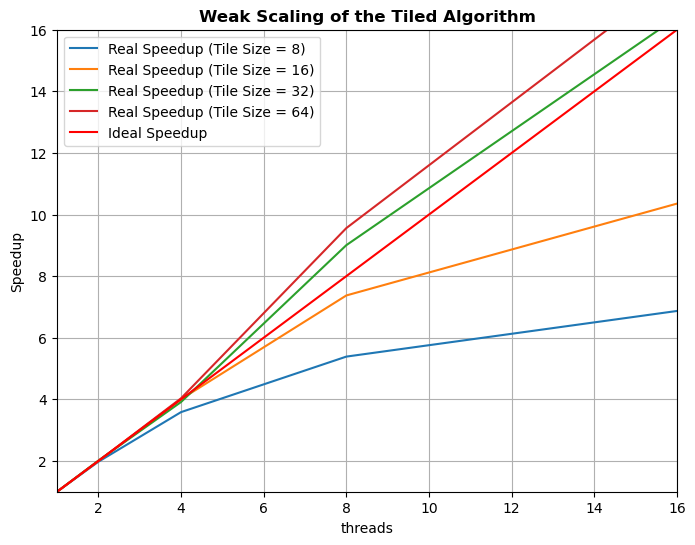

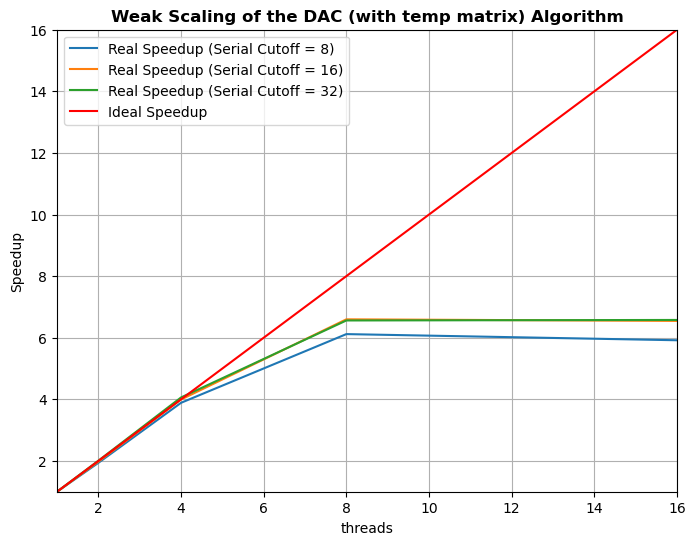

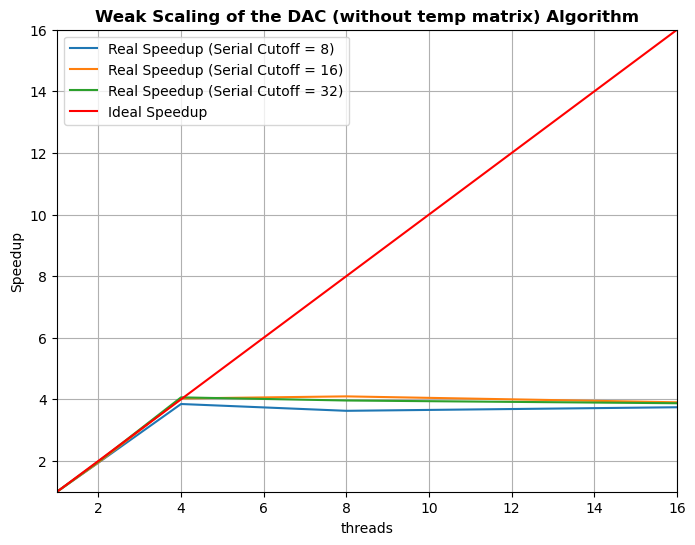

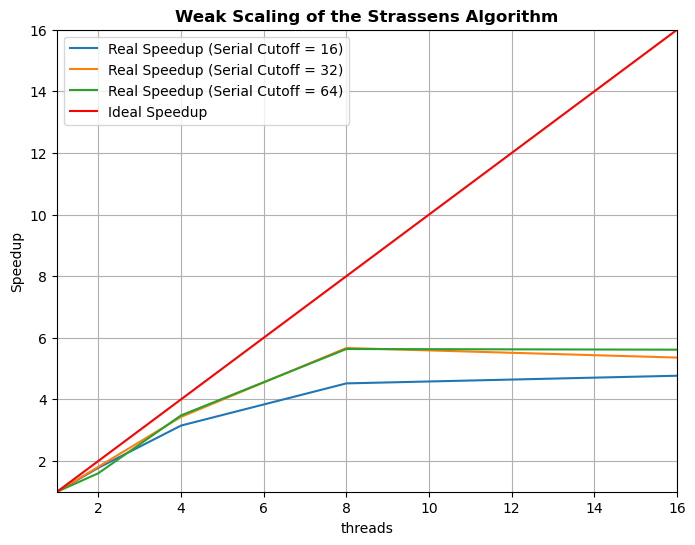

In [10]:
plot_weak_scaling(parfor_median, "threads", "Speedup", "Parallel For")
plot_weak_scaling(tiled_median, "threads", "Speedup", "Tiled", "Tile Size")
plot_weak_scaling(dac_temp_median, "threads", "Speedup", "DAC (with temp matrix)", "Serial Cutoff")
plot_weak_scaling(dac_notemp_median, "threads", "Speedup", "DAC (without temp matrix)", "Serial Cutoff")
plot_weak_scaling(strassens_median, "threads", "Speedup", "Strassens", "Serial Cutoff")

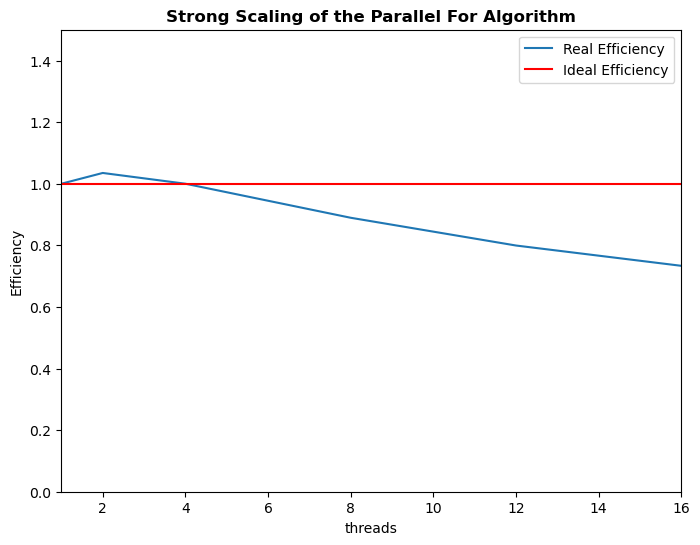

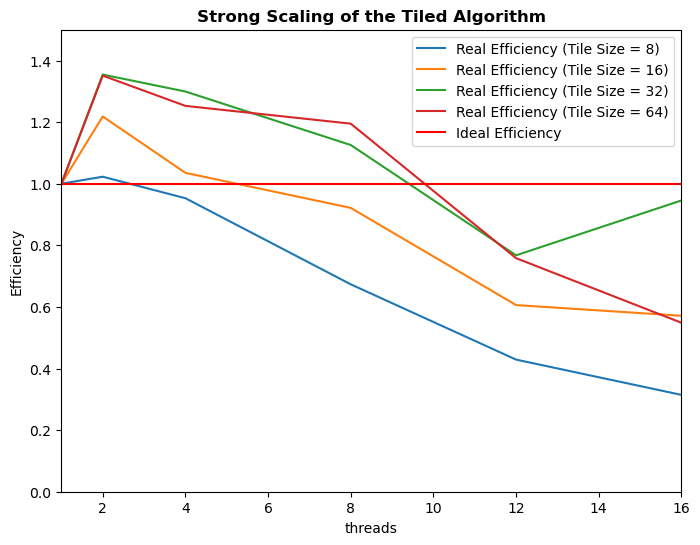

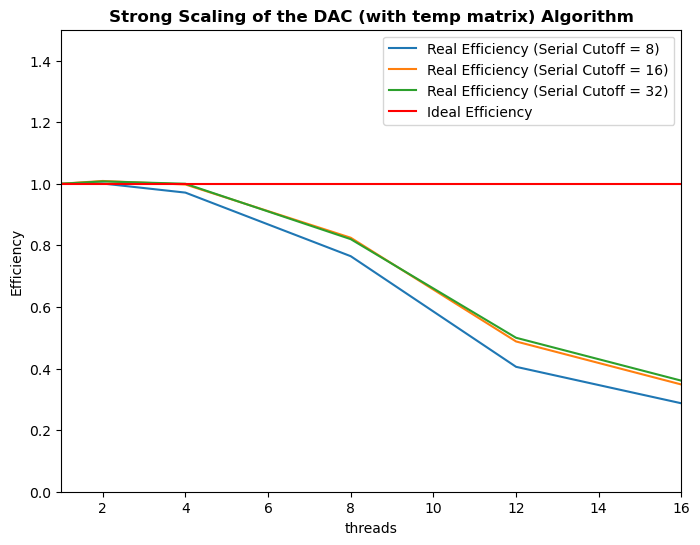

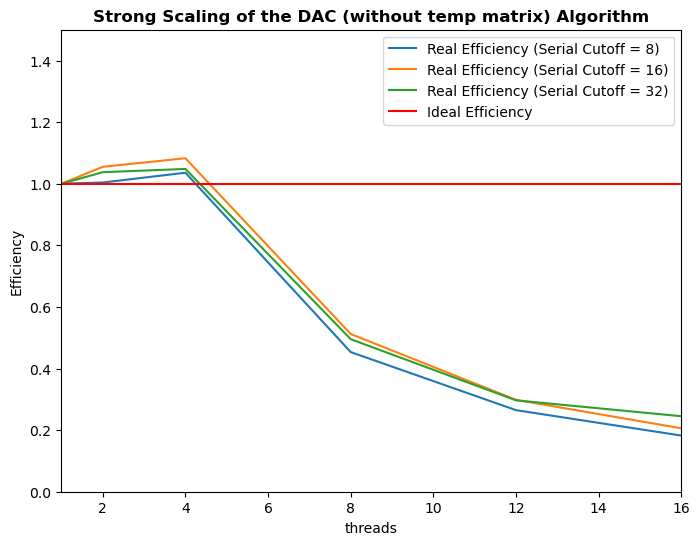

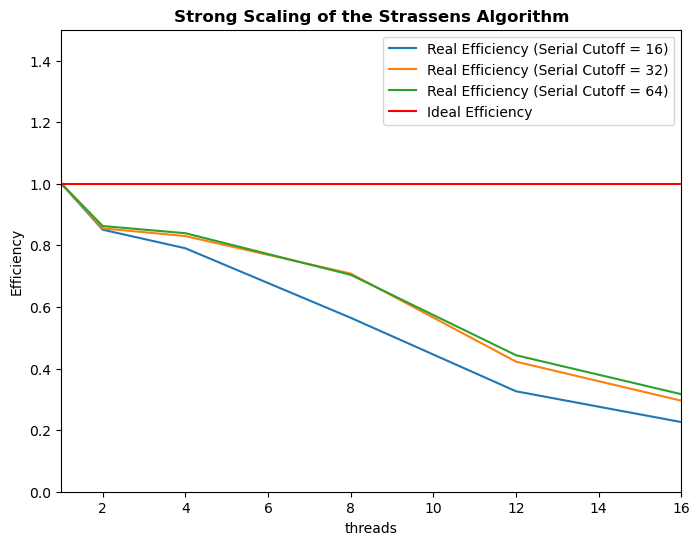

In [11]:
max_N = 512
plot_strong_scaling(parfor_median[parfor_median["N"] == max_N], "threads", "Efficiency", "Parallel For")
plot_strong_scaling(tiled_median[tiled_median["N"] == max_N], "threads", "Efficiency", "Tiled", "Tile Size")
plot_strong_scaling(dac_temp_median[dac_temp_median["N"] == max_N], "threads", "Efficiency", "DAC (with temp matrix)", "Serial Cutoff")
plot_strong_scaling(dac_notemp_median[dac_notemp_median["N"] == max_N], "threads", "Efficiency", "DAC (without temp matrix)", "Serial Cutoff")
plot_strong_scaling(strassens_median[strassens_median["N"] == max_N], "threads", "Efficiency", "Strassens", "Serial Cutoff")

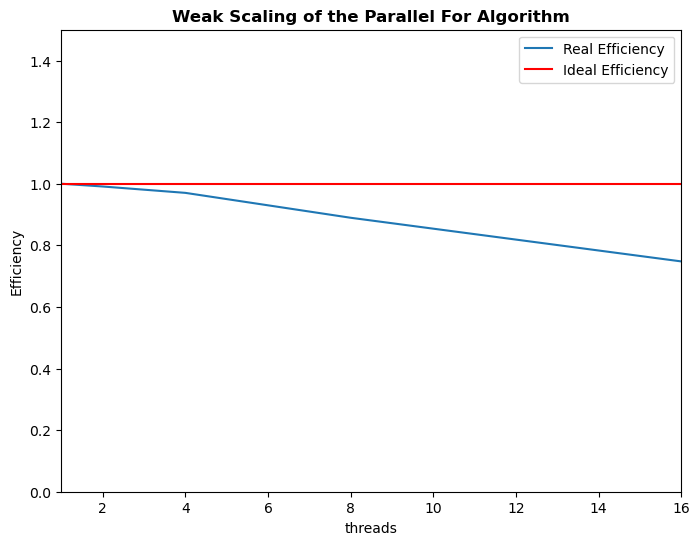

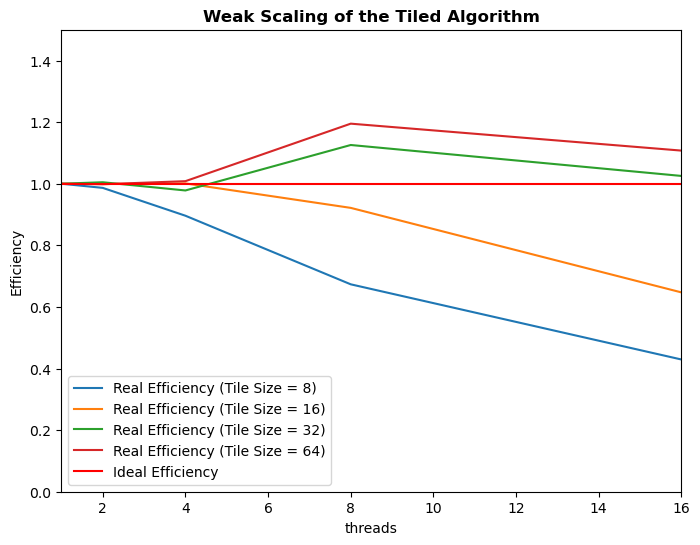

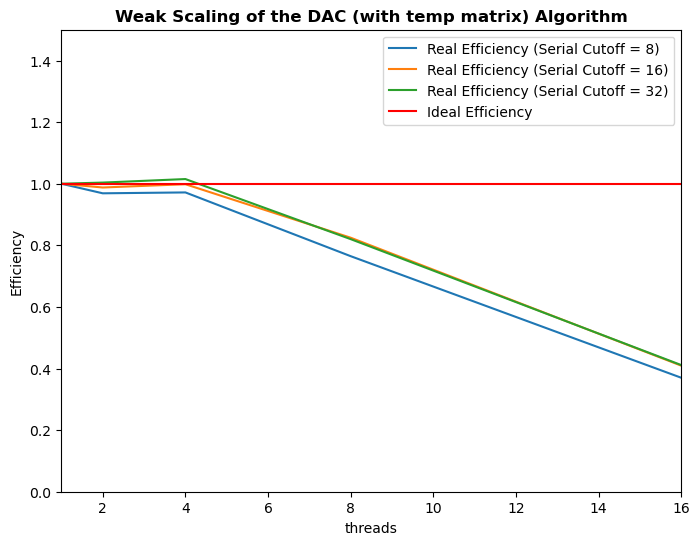

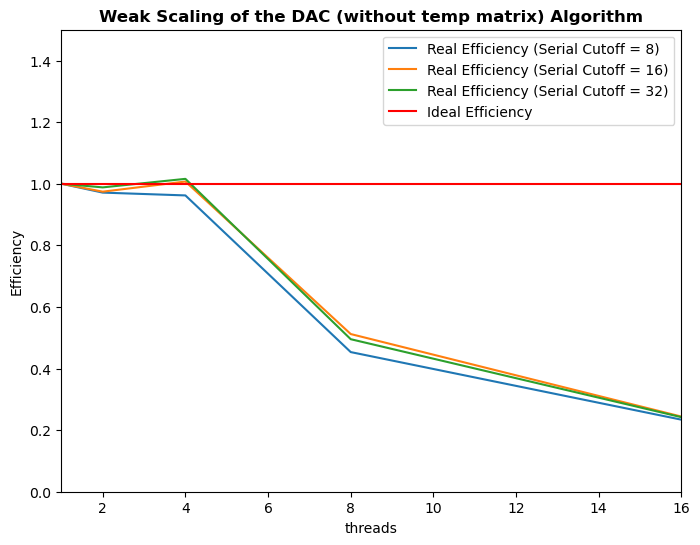

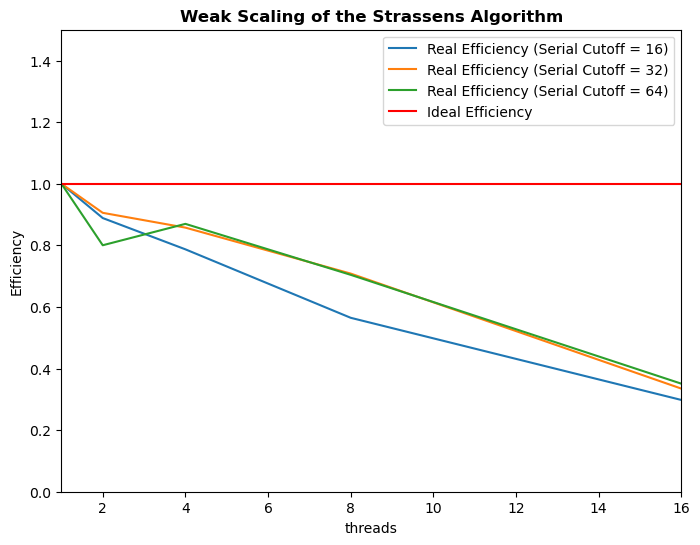

In [12]:
plot_weak_scaling(parfor_median, "threads", "Efficiency", "Parallel For")
plot_weak_scaling(tiled_median, "threads", "Efficiency", "Tiled", "Tile Size")
plot_weak_scaling(dac_temp_median, "threads", "Efficiency", "DAC (with temp matrix)", "Serial Cutoff")
plot_weak_scaling(dac_notemp_median, "threads", "Efficiency", "DAC (without temp matrix)", "Serial Cutoff")
plot_weak_scaling(strassens_median, "threads", "Efficiency", "Strassens", "Serial Cutoff")

In [29]:
all_runs = pd.concat(dfs).reset_index(drop=True)
all_runs.loc[all_runs.groupby(["threads", "N"])["runtime(ms)"].idxmin()]

,threads,N,algorithm,runtime(ms),param,serial_runtime(ms),Speedup,Efficiency
42,1,64,tiled,0.22150,8.0,0.22150,1.000000,1.000000
46,1,128,tiled,1.79180,8.0,1.79180,1.000000,1.000000
50,1,256,tiled,14.79595,8.0,14.79595,1.000000,1.000000
54,1,512,tiled,167.82650,8.0,167.82650,1.000000,1.000000
58,1,1024,tiled,1288.70000,8.0,1288.70000,1.000000,1.000000
418,1,2048,strassens,10247.80000,32.0,10247.80000,1.000000,1.000000
66,2,64,tiled,0.14300,8.0,0.22150,1.548951,0.774476
70,2,128,tiled,0.90815,8.0,1.79180,1.973022,0.986511
74,2,256,tiled,7.64435,8.0,14.79595,1.935541,0.967770
78,2,512,tiled,82.04705,8.0,167.82650,2.045491,1.022745
